# Forest

## Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()


## EXAMPLE: TRAIN FROM 2021-12, PREDICT FOR 2022-01

In [2]:
df = pd.read_sql(
    """
    select ticker, date, agr, bm, idiovol, mom12m, roeq, ret
    from data
    where date in ('2021-12', '2022-01')
    """, 
    conn
)
features = ["agr", "bm", "idiovol", "mom12m", "roeq"]

## TRANSFORM EACH CROSS-SECTION

In [3]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")

def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[features + ["ret"]] = df.groupby(
  "date", 
  group_keys=False
)[features + ["ret"]].apply(qtxs)

## FITTING A RANDOM FOREST

In [5]:
from sklearn.ensemble import RandomForestRegressor

df = df.dropna()

Xtrain = df[df.date=='2021-12'][features]
ytrain = df[df.date=='2021-12']["ret"]

model = RandomForestRegressor(
  max_depth=3,
  random_state=0
)
model.fit(Xtrain, ytrain)

RandomForestRegressor(max_depth=3, random_state=0)

## SCORES ON TRAINING AND TEST DATA

### R-squared on training data

In [6]:
model.score(Xtrain, ytrain)

0.22976788069509535

### R-squared on test data

In [7]:
Xtest = df[df.date=='2022-01'][features]
ytest = df[df.date=='2022-01']["ret"]
model.score(Xtest, ytest)

0.04531974055201915

In [8]:
train_score = []
test_score = []
for i in range(1, 11):
    model = RandomForestRegressor(
        max_depth=i,
        random_state=0
        )
    model.fit(Xtrain, ytrain)
    train_score.append(model.score(Xtrain, ytrain))
    test_score.append(model.score(Xtest, ytest))

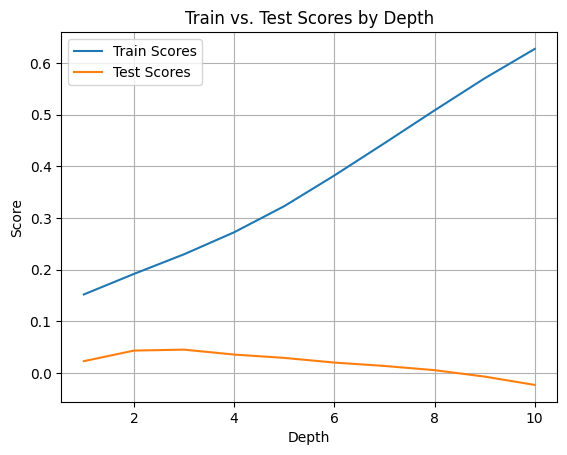

In [9]:
import matplotlib.pyplot as plt



depths = range(1,11)

plt.plot(depths, train_score, label='Train Scores')
plt.plot(depths, test_score, label='Test Scores')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Train vs. Test Scores by Depth')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## FITTING GRADIENT BOOSTING

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
  max_depth=3,
  learning_rate=0.05,
  random_state=0
)
model.fit(Xtrain, ytrain)

GradientBoostingRegressor(learning_rate=0.05, random_state=0)

## SCORES ON TRAINING AND TEST DATA

### R-squared on training data

In [11]:
model.score(Xtrain, ytrain)

0.3182800705130283

### R-squared on test data

In [12]:
Xtest = df[df.date=='2022-01'][features]
ytest = df[df.date=='2022-01']["ret"]
model.score(Xtest, ytest)

0.038327956389705986

In [13]:
test_scores = []
for learning_rate in [0.01, 0.05, 0.1, 0.2]:
    test_score = []
    for i in range(1, 11):
        model = GradientBoostingRegressor(
            max_depth=i,
            learning_rate=learning_rate,
            random_state=0
            )
        model.fit(Xtrain, ytrain)
        test_score.append(model.score(Xtest, ytest))
    test_scores.append(test_score)

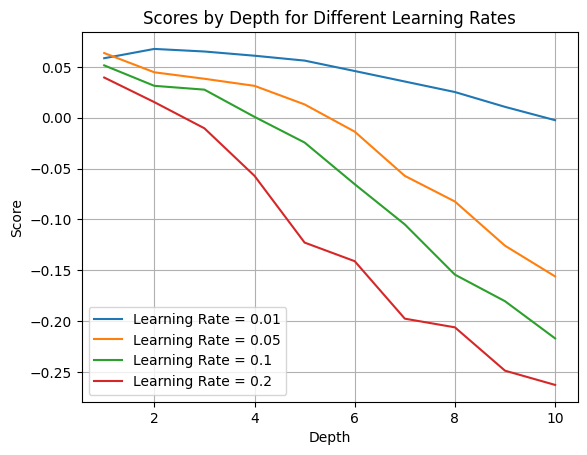

In [14]:
import matplotlib.pyplot as plt

depths = range(1,11)

# Create the plot
plt.plot(depths, test_scores[0], label='Learning Rate = 0.01')
plt.plot(depths, test_scores[1], label='Learning Rate = 0.05')
plt.plot(depths, test_scores[2], label='Learning Rate = 0.1')
plt.plot(depths, test_scores[3], label='Learning Rate = 0.2')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Scores by Depth for Different Learning Rates')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()

## FITTING ADAPTIVE BOOSTING

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(
    DecisionTreeRegressor(
        max_depth=3,
        random_state=0
    ),
    learning_rate=0.5,
)
model.fit(Xtrain, ytrain)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                       random_state=0),
                  learning_rate=0.5)

## SCORES ON TRAINING AND TEST DATA

### R-squared on training data

In [16]:
model.score(Xtrain, ytrain)

0.1570760114519858

### R-squared on test data

In [17]:
Xtest = df[df.date=='2022-01'][features]
ytest = df[df.date=='2022-01']["ret"]
model.score(Xtest, ytest)

0.057925889304100364

In [20]:
test_scores = []
for learning_rate in [0.05, 0.1, 0.2, 0.5]:
    test_score = []
    for i in range(1, 11):
        model = AdaBoostRegressor(
            DecisionTreeRegressor(
                max_depth=i,
                random_state=0
            ),
            learning_rate=learning_rate,
        )
        model.fit(Xtrain, ytrain)
        test_score.append(model.score(Xtest, ytest))
    test_scores.append(test_score)

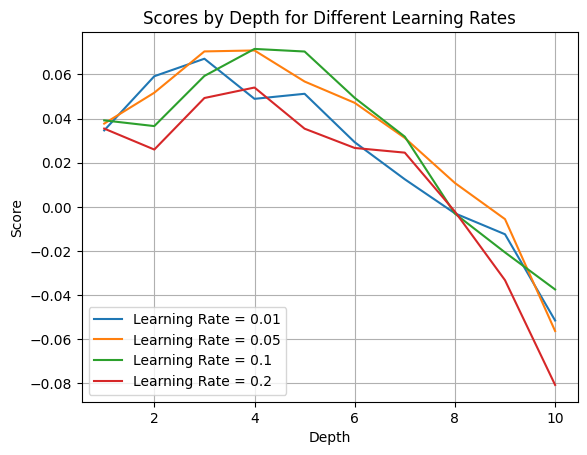

In [21]:
import matplotlib.pyplot as plt

depths = range(1,11)

# Create the plot
plt.plot(depths, test_scores[0], label='Learning Rate = 0.01')
plt.plot(depths, test_scores[1], label='Learning Rate = 0.05')
plt.plot(depths, test_scores[2], label='Learning Rate = 0.1')
plt.plot(depths, test_scores[3], label='Learning Rate = 0.2')

# Add labels and legend
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Scores by Depth for Different Learning Rates')
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()